## Intro
I'll be creating a convolutional neural network (CNN) to classify images of Melanoma, Nevus and Seborrheic Keratosis.

Melanoma are the malignant conditions (these are bad cancer), while Nevus and Seborrheic Keratosis are benign skin lesions.

## Step 1: Get our data

In [1]:
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np
from glob import glob

# function to load our datasets
def load_data(path):
    data = load_files(path)
    skin_files = np.array(data["filenames"])
    skin_targets = np_utils.to_categorical(np.array(data["target"]),3)
    return skin_files, skin_targets

# load our datasets
train_files, train_targets = load_data("data/train")
test_files, test_targets = load_data("data/test")
validation_files, validation_targets = load_data("data/valid")

# load a list of condition names
condition_names = [item[20:-1] for item in sorted(glob("data/train/*/"))]

# print statistics about the dataset
print('There are %d total conditions.' % len(condition_names))
print('There are %s total skin images.\n' % len(np.hstack([train_files, validation_files, test_files])))
print('There are %d training skin images.' % len(train_files))
print('There are %d validation skin images.' % len(validation_files))
print('There are %d test skin images.'% len(test_files))

Using TensorFlow backend.


There are 3 total conditions.
There are 2750 total skin images.

There are 2000 training skin images.
There are 150 validation skin images.
There are 600 test skin images.


In [2]:
# Visualize what the data looks like
print(train_files[0])

data/train\nevus\ISIC_0000045.jpg


## Step 2: Data prep

Original Image:


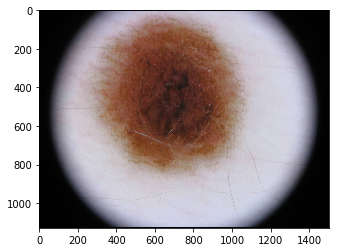

Original Image resized to 224x224:


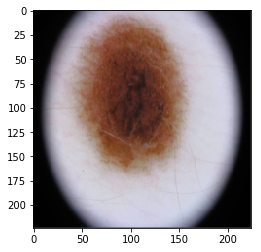

Shape of the tensor:
(1, 224, 224, 3)


In [2]:
from keras.preprocessing import image
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt                        
%matplotlib inline

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

def show_image(img_path=""):
    # load color (BGR) image
    img = cv2.imread(img_path)
        
    # convert BGR to RGB
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
    plt.imshow(cv_rgb)
    plt.show()
    return

# Test the functions on the first training image
print("Original Image:")
show_image(train_files[0])

resized_image = image.load_img(train_files[0], target_size=(224,224))
print("Original Image resized to 224x224:")
plt.imshow(resized_image)
plt.show()

print("Shape of the tensor:")
print(path_to_tensor(train_files[0]).shape)


In [3]:
# Pre-process our data for Keras
train_tensors = paths_to_tensor(train_files).astype("float32")/255
validation_tensors = paths_to_tensor(validation_files).astype("float32")/255
test_tensors = paths_to_tensor(test_files).astype("float32")/255

100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [03:17<00:00,  3.04it/s]


## Create our own CNN

In [4]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### TODO: Define your architecture.

# our input data is 1 x 224 x 224 x 3
# The first layer we add is the same as in the cifar10 cnn, but with more filters due to
# our larger input data 
model.add(Conv2D(filters = 32, kernel_size = 4, padding="same",
                 activation ="relu", input_shape = (224, 224, 3)))

# the second layer will be a pooling layer of 2
model.add(MaxPooling2D(pool_size=2))

# the third layer is another conv2D with half the size and double the filters of the first layer
model.add(Conv2D(filters=64, kernel_size=4, padding="same", activation="relu"))

# as a fourth lmayer we add yet another pooling layer
model.add(MaxPooling2D(pool_size=2))

# repeat the process one more time 
model.add(Conv2D(filters=128, kernel_size=4, padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=2))

# add dropout and dense layers, and gradually increase dropout untill 0.75
# I set a maximum dropout of 0.75 to make our model unlikely to overfit and 
# make it generalise good
model.add(Dropout(0.2))
model.add(Dense(500, activation="relu"))

model.add(Dropout(0.3))
model.add(Dense(350, activation="relu"))

model.add(Dropout(0.5))
model.add(Dense(225, activation="relu"))

#model.add(Flatten())
model.add(GlobalAveragePooling2D()) 
# Changed flatten to GlobalAveragePooling2D because flatten would 
# result in millions of parameters, which would take a very long time to train

model.add(Dropout(0.75))
model.add(Dense(3, activation="softmax"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      1568      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      32832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 128)       131200    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 128)       0         
__________

In [5]:
from keras import optimizers
"""
learn_rate = 0.0001
momentum = 0.0
decay = 0.001

optimizer = optimizers.SGD(lr=learn_rate, momentum=momentum, decay=decay)"""
model.compile(optimizer="rmsprop", loss='categorical_crossentropy', metrics=['accuracy'])

In [6]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 10

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(validation_tensors, validation_targets),
          epochs=epochs, batch_size=64, callbacks=[checkpointer], verbose=2 )

Train on 2000 samples, validate on 150 samples
Epoch 1/10
Epoch 00001: val_loss improved from inf to 1.42561, saving model to saved_models/weights.best.from_scratch.hdf5
 - 15s - loss: 0.9034 - acc: 0.6715 - val_loss: 1.4256 - val_acc: 0.5200
Epoch 2/10
Epoch 00002: val_loss improved from 1.42561 to 1.03686, saving model to saved_models/weights.best.from_scratch.hdf5
 - 12s - loss: 0.8638 - acc: 0.6860 - val_loss: 1.0369 - val_acc: 0.5200
Epoch 3/10
Epoch 00003: val_loss improved from 1.03686 to 1.02412, saving model to saved_models/weights.best.from_scratch.hdf5
 - 11s - loss: 0.8616 - acc: 0.6860 - val_loss: 1.0241 - val_acc: 0.5200
Epoch 4/10
Epoch 00004: val_loss did not improve
 - 15s - loss: 0.8590 - acc: 0.6860 - val_loss: 1.0829 - val_acc: 0.5200
Epoch 5/10
Epoch 00005: val_loss did not improve
 - 11s - loss: 0.8490 - acc: 0.6860 - val_loss: 1.1868 - val_acc: 0.5200
Epoch 6/10
Epoch 00006: val_loss improved from 1.02412 to 1.00538, saving model to saved_models/weights.best.from

In [7]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

In [8]:
# get index of predicted dog breed for each image in test set
predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(test_targets, axis=1))/len(predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 65.5000%


## Results
I'm finding it pretty strange that my model is coming up with exactly 65.5%. I would expect it to have more digits after the decimal points. Also, the accuracy does not change with more training. 50 epochs gave me the exact same accuracy.

# Let's try transfer learning

In [15]:
from keras.applications.vgg16 import VGG16
from keras.models import Model

# create the pre-trained model
base_model = VGG16(weights="imagenet", include_top=False)

# add our output layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(3, activation="softmax")(x)

# create the final model
final_model = Model(inputs=base_model.input, outputs=predictions)

# set the layers in the base model to untrainable
for layer in base_model.layers:
    layer.trainable = False

In [17]:
learn_rate = 0.0001
momentum = 0.0
decay = 0.001

optimizer = optimizers.SGD(lr=learn_rate, momentum=momentum, decay=decay)


final_model.compile(loss="categorical_crossentropy",optimizer=optimizer, metrics=["accuracy"])
print(final_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [18]:
VGG16_checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

epochs = 25
batch_size = 32

model_info = final_model.fit(train_tensors, train_targets,
                             validation_data=(validation_tensors, validation_targets),
                             epochs=epochs, batch_size=batch_size, verbose=2,
                             callbacks=[VGG16_checkpointer])

Train on 2000 samples, validate on 150 samples
Epoch 1/25
Epoch 00001: val_loss improved from inf to 1.06984, saving model to saved_models/weights.best.VGG16.hdf5
 - 20s - loss: 0.9487 - acc: 0.6810 - val_loss: 1.0698 - val_acc: 0.5200
Epoch 2/25
Epoch 00002: val_loss improved from 1.06984 to 1.06712, saving model to saved_models/weights.best.VGG16.hdf5
 - 19s - loss: 0.8956 - acc: 0.6870 - val_loss: 1.0671 - val_acc: 0.5200
Epoch 3/25
Epoch 00003: val_loss did not improve
 - 19s - loss: 0.8695 - acc: 0.6865 - val_loss: 1.0719 - val_acc: 0.5200
Epoch 4/25
Epoch 00004: val_loss did not improve
 - 19s - loss: 0.8557 - acc: 0.6860 - val_loss: 1.0784 - val_acc: 0.5200
Epoch 5/25
Epoch 00005: val_loss did not improve
 - 19s - loss: 0.8482 - acc: 0.6860 - val_loss: 1.0849 - val_acc: 0.5200
Epoch 6/25
Epoch 00006: val_loss did not improve
 - 19s - loss: 0.8437 - acc: 0.6860 - val_loss: 1.0906 - val_acc: 0.5200
Epoch 7/25
Epoch 00007: val_loss did not improve
 - 19s - loss: 0.8410 - acc: 0.686

In [12]:
final_model.load_weights('saved_models/weights.best.VGG16.hdf5')

In [13]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(final_model.predict(np.expand_dims(feature, axis=0))) for feature in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 65.5000%


In [14]:
# Final evaluation of the model
scores = final_model.evaluate(test_tensors, test_targets, verbose=2)
print("Error: %.2f%%" % ((1-scores[1])*100))

Error: 34.50%


## Results
Also here we end up with a max of exactly 65.5%. I'm starting to think that there is a problem with my testing or some limit on how I'm training the model.